In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('Solarize_Light2')

In [2]:
from keras.layers import Input, LSTM, Dense, TimeDistributed
from keras import Model
from keras.metrics import AUC

In [3]:
df = pd.read_csv("./panel_wage.csv")

<AxesSubplot:ylabel='Density'>

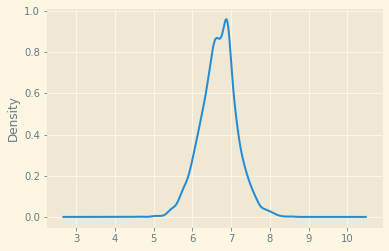

In [4]:
df["lwage"].plot(kind="density")

In [5]:
df["lwage_cat"] = pd.cut(df["lwage"], [0, 7, np.Inf], labels=[0, 1]).astype("int")

In [6]:
X = np.array([df.loc[:,"exp":"id"].groupby('id').get_group(i).values[:,:-2] for i in range(1, 596)])
Y = np.array([df.loc[:,["id","lwage_cat"]].groupby('id').get_group(i).values[:,1:] for i in range(1, 596)])

In [7]:
print(X.shape)
print(Y.shape)

(595, 7, 11)
(595, 7, 1)


In [8]:
input_layer = Input(shape=(7,11,))
encoder = LSTM(32, return_sequences=True, dropout=0.1)(input_layer)
decoder = LSTM(32, return_sequences=True, dropout=0.1)(encoder)
output = TimeDistributed(Dense(1, activation="sigmoid"))(decoder)
model = Model(inputs=input_layer, outputs=output)

2022-07-15 22:43:00.349494: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [9]:
auc = AUC(name="auc")
model.compile(optimizer="adam", loss="binary_crossentropy", metrics=[auc])

In [10]:
hist = model.fit(X, Y, batch_size=32, epochs=20, verbose=1)

Epoch 1/20
19/19 [==============================] - 3s 7ms/step - loss: 0.6252 - auc: 0.3738
Epoch 2/20
19/19 [==============================] - 0s 5ms/step - loss: 0.5809 - auc: 0.3149
Epoch 3/20
19/19 [==============================] - 0s 5ms/step - loss: 0.5415 - auc: 0.5060
Epoch 4/20
19/19 [==============================] - 0s 5ms/step - loss: 0.4873 - auc: 0.7296
Epoch 5/20
19/19 [==============================] - 0s 5ms/step - loss: 0.4316 - auc: 0.7989
Epoch 6/20
19/19 [==============================] - 0s 5ms/step - loss: 0.3988 - auc: 0.8350
Epoch 7/20
19/19 [==============================] - 0s 5ms/step - loss: 0.3758 - auc: 0.8546
Epoch 8/20
19/19 [==============================] - 0s 5ms/step - loss: 0.3745 - auc: 0.8555
Epoch 9/20
19/19 [==============================] - 0s 5ms/step - loss: 0.3606 - auc: 0.8688
Epoch 10/20
19/19 [==============================] - 0s 5ms/step - loss: 0.3488 - auc: 0.8784
Epoch 11/20
19/19 [==============================] - 0s 5ms/step - lo

In [11]:
Yh = model.predict(X)

19/19 [==============================] - 1s 2ms/step


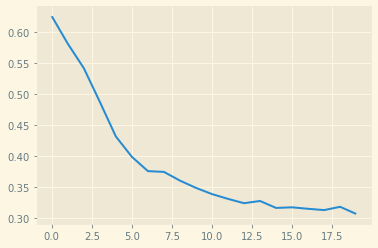

In [13]:
plt.plot(hist.history["loss"])

In [14]:
from panel_data_example import stratified_auc, auc_w

In [32]:
Yh = model.predict(X)
outcome_data = pd.DataFrame()
outcome_data["outcome"] = df["lwage_cat"]
outcome_data["p"] = Yh.reshape((-1))
outcome_data["count"] = df["t"]

19/19 [==============================] - 0s 4ms/step


In [33]:
auc_w(stratified_auc(outcome_data))

0.6116787365504675

/var/folders/ql/g2lrtrss1ns2qlwbvzmvtgzm0000gn/T/ipykernel_24605/3921395573.py:3: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar(orientation='vertical')


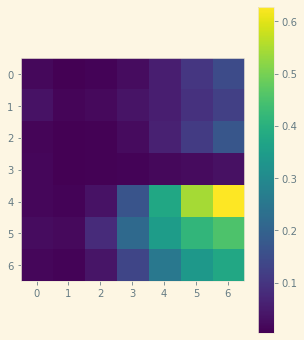

In [35]:
plt.figure(figsize=(5,6))
plt.imshow(Yh[:7,:])
plt.colorbar(orientation='vertical')
plt.grid(False)

### Random data generator

In [22]:
from panel_data_example import train_generator

In [23]:
g = train_generator()

In [24]:
data = [next(g)[0] for _ in range(5)]

In [25]:
for elem in data:
	print(elem.shape)

(248, 11, 5)
(248, 1, 5)
(248, 7, 5)
(248, 2, 5)
(248, 4, 5)


In [26]:
data[0][0].shape

(11, 5)